In [18]:
!pip install wandb
!pip install wordcloud
!pip install colour

In [19]:
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-lohit-deva is already the newest version (2.95.4-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Lohit Devanagari


In [20]:
import os
import random
import time
import wandb
import re, string
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer

In [21]:
wandb.login()

True

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
## Download the dataset ##
import requests
import tarfile

def download_data(save_path):

    data_url = r"https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

    r = requests.get(data_url, allow_redirects=True)
    tar_path = "data_assignment3.tar"

    if r.status_code == 200:
        with open(tar_path, 'wb') as f:
            f.write(r.content)

    tar_file = tarfile.open(tar_path)
    tar_file.extractall(save_path)
    tar_file.close()

In [24]:
def get_data_files(language):

    template = "/content/drive/MyDrive/dakshina_dataset_v1.0/{}/lexicons/{}.translit.sampled.{}.tsv"

    train_tsv = template.format(language, language, "train")
    val_tsv = template.format(language, language, "dev")
    test_tsv = template.format(language, language, "test")
    return train_tsv, val_tsv, test_tsv

# Utility functions for preprocessing data

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    def add_tokens(s):  
        return sos + str(s) + eos

    for col in cols:
        df[col] = df[col].apply(add_tokens) 
    
def tokenize(lang, tokenizer=None):

    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor, padding='post')
    else: 
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor, padding='post')
    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):

    df = pd.read_csv(fpath, sep="\t", header=None)
    # adding start and end tokens to know when to stop predicting 
    add_start_end_tokens(df, [0,1])
    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(), tokenizer=input_lang_tokenizer)
    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(), tokenizer=targ_lang_tokenizer) 
    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))
    return dataset, input_tokenizer, targ_tokenizer

In [25]:
## Utility functions ##
def get_layer(name, units, dropout, return_state=False, return_sequences=False):

    if name=="lstm":
        return layers.LSTM(units=units, dropout=dropout, 
                           return_state=return_state,
                           return_sequences=return_sequences)

    if name=="gru":
        return layers.GRU(units=units, dropout=dropout, 
                          return_state=return_state,
                          return_sequences=return_sequences)
        
    if name=="rnn":
        return layers.SimpleRNN(units=units, dropout=dropout, 
                                return_state=return_state,
                                return_sequences=return_sequences)

    

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, enc_state, enc_out): 
    enc_state = tf.concat(enc_state, 1)
    enc_state = tf.expand_dims(enc_state, 1)
    score = self.V(tf.nn.tanh(self.W1(enc_state) + self.W2(enc_out)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * enc_out
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights


class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, encoder_vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.embedding = tf.keras.layers.Embedding(encoder_vocab_size, embedding_dim)
        self.create_rnn_layers()

    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.rnn_layers[0](x, initial_state=hidden)
        for layer in self.rnn_layers[1:]:
            x = layer(x)
        output, state = x[0], x[1:]
        return output, state

    def initialize_hidden_state(self, batch_size):
        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units))]*2

    def create_rnn_layers(self):
    self.rnn_layers = []
    for i in range(self.n_layers):
        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                            return_sequences=True,
                                            return_state=True))

class Decoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, decoder_vocab_size, embedding_dim, dropout, attention=False):
        super(Decoder, self).__init__()
        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.embedding_layer = layers.Embedding(input_dim=decoder_vocab_size, 
                                                output_dim=embedding_dim)
        
        self.dense = layers.Dense(decoder_vocab_size, activation="softmax")
        self.flatten = layers.Flatten()
        if self.attention:
            self.attention_layer = BahdanauAttention(self.units)
        self.create_rnn_layers()

    def call(self, x, hidden, enc_out=None): 
        x = self.embedding_layer(x)
        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None
        x = self.rnn_layers[0](x, initial_state=hidden)

        for layer in self.rnn_layers[1:]:
            x = layer(x)
        output, state = x[0], x[1:]
        output = self.dense(self.flatten(output))   
        return output, state, attention_weights

    def create_rnn_layers(self):
        self.rnn_layers = []   
        for i in range(self.n_layers - 1):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))
        
        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                            return_sequences=False,
                                            return_state=True))

class Seq2SeqModel():
    def __init__(self, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention=False):
        self.embedding_dim = embedding_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.batch_size = 128
        self.use_beam_search = False

    def build(self, loss, optimizer, metric):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()
    
    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1

        self.encoder = Encoder(self.layer_type, self.encoder_layers, self.units, encoder_vocab_size,
                               self.embedding_dim, self.dropout)

        self.decoder = Decoder(self.layer_type, self.decoder_layers, self.units, decoder_vocab_size,
                               self.embedding_dim,  self.dropout, self.attention)

    @tf.function
    def train_step(self, input, target, enc_state):
        loss = 0 
        with tf.GradientTape() as tape: 
            enc_out, enc_state = self.encoder(input, enc_state)
            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            if random.random() < self.teacher_forcing_ratio:
                for t in range(1, target.shape[1]):
                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)                   
                    dec_input = tf.expand_dims(target[:,t], 1)            
            else:

                for t in range(1, target.shape[1]):
                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)
                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)
            batch_loss = loss / target.shape[1]
            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss, self.metric.result()

    @tf.function
    def validation_step(self, input, target, enc_state):
        loss = 0        
        enc_out, enc_state = self.encoder(input, enc_state)
        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)
        for t in range(1, target.shape[1]):
            preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
            loss += self.loss(target[:,t], preds)
            self.metric.update_state(target[:,t], preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)
        batch_loss = loss / target.shape[1]       
        return batch_loss, self.metric.result()


    def fit(self, dataset, val_dataset, batch_size=128, epochs=10, use_wandb=False, teacher_forcing_ratio=1.0):

        self.batch_size = batch_size
        self.teacher_forcing_ratio = teacher_forcing_ratio

        steps_per_epoch = len(dataset) // self.batch_size
        steps_per_epoch_val = len(val_dataset) // self.batch_size
        
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        val_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)

        # useful when we need to translate the sentence
        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        template = "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}"

        print("-"*100)
        for epoch in range(1, epochs+1):
            print(f"EPOCH {epoch}\n")

            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_states()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("Training ...\n")
            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                batch_loss, acc = self.train_step(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc
                if batch==0 or ((batch + 1) % 100 == 0):
                    print(f"Batch {batch+1} Loss {batch_loss:.4f}")

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_states()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("\nValidating ...")
            for batch, (input, target) in enumerate(val_dataset.take(steps_per_epoch_val)):
                batch_loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss += batch_loss
                total_val_acc += acc

            avg_val_acc = total_val_acc / steps_per_epoch_val
            avg_val_loss = total_val_loss / steps_per_epoch_val

            print(template.format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))
            
            time_taken = time.time() - starting_time
            self.stats.append({"epoch": epoch,
                            "train loss": avg_loss,
                            "val loss": avg_val_loss,
                            "train acc": avg_acc*100,
                            "val acc": avg_val_acc*100,
                            "training time": time_taken})
            
            if use_wandb:
                wandb.log(self.stats[-1])
            
            print(f"\nTime taken for the epoch {time_taken:.4f}")
            print("-"*100)
        
        print("\nModel trained successfully !!")
        
    def evaluate(self, test_dataset, batch_size=None):
        if batch_size is not None:
            self.batch_size = batch_size
        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)      
        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_states()
        enc_state = self.encoder.initialize_hidden_state(self.batch_size)
        print("\nRunning test dataset through the model...\n")
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation_step(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc
        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test    
        print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")
        return avg_test_loss, avg_test_acc


    def translate(self, word, get_heatmap=False):
        word = "\t" + word + "\n"
        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=self.max_input_len, padding="post")
        result = ""
        att_wts = []
        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)
        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.max_target_len):
            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)          
            if get_heatmap:
                att_wts.append(attention_weights)           
            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char
            dec_input = tf.expand_dims(preds, 1)
            if next_char == "\n":
                return result[:-1], att_wts[:-1]
        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):
        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()
        input_word_len = len(word)
        output_word_len = len(translated_word)
        ax.imshow(attn_heatmap[:, :input_word_len])
        font_prop = FontProperties(fname=font_path, size=18)
        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))
        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


In [26]:
def get_colors(inputs, targets, preds):

    n = len(targets)
    smoother = SmoothingFunction().method2
    def get_scores(target, output, smoother):
        return sentence_bleu(list(list(target)), list(output), smoothing_function=smoother)

    red = Color("red")
    colors = list(red.range_to(Color("violet"),n))
    colors = list(map(lambda c: c.hex, colors))

    scores = []
    for i in range(n):
        scores.append(get_scores(targets[i], preds[i], smoother))

    d = dict(zip(sorted(scores), list(range(n))))
    ordered_colors = list(map(lambda x: colors[d[x]], scores))
    
    input_colors = dict(zip(inputs, ordered_colors))
    target_colors = dict(zip(targets, ordered_colors))
    pred_colors = dict(zip(preds, ordered_colors))

    return input_colors, target_colors, pred_colors


class Colorizer():
    def __init__(self, word_to_color, default_color):
       
        self.word_to_color = word_to_color
        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

def randomly_evaluate(model, test_file=get_data_files("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])

        print(f"Input word: {word}")
        print(f"Actual translation: {str(df[0][i])}")
        print(f"Model translation: {model.translate(word)[0]}\n")

def visualize_model_outputs(model, test_file=get_data_files("hi")[2], n=10, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    inputs = df[1].astype(str).tolist()
    targets = df[0].astype(str).tolist()
    preds = list(map(lambda word: model.translate(word)[0], inputs))

    # Generate colors for the words
    input_colors, target_colors, pred_colors =  get_colors(inputs, targets, preds)
    color_fn_ip = Colorizer(input_colors, "white")
    color_fn_tr = Colorizer(target_colors, "white")
    color_fn_op = Colorizer(pred_colors, "white")

    input_text = Counter(inputs)
    target_text = Counter(targets)
    output_text = Counter(preds)

    fig, axs = plt.subplots(1,3, figsize=(30, 15))
    plt.tight_layout()

    wc_in = WordCloud(random_state=1).generate_from_frequencies(input_text)
    wc_out = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(output_text)
    wc_tar = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(target_text)

    axs[0].set_title("Input words", fontsize=30)
    axs[0].imshow(wc_in.recolor(color_func=color_fn_ip))
    axs[1].set_title("Target words", fontsize=30)
    axs[1].imshow(wc_tar.recolor(color_func=color_fn_tr))
    axs[2].set_title("Model outputs", fontsize=30)
    axs[2].imshow(wc_out.recolor(color_func=color_fn_op))
    plt.show()
    


def test_on_dataset(language, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention, teacher_forcing_ratio=1.0, save_outputs=None):
    
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    model = Seq2SeqModel(embedding_dim, 
                         encoder_layers, 
                         decoder_layers, 
                         layer_type, 
                         units,
                         dropout,
                         attention)

    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())
    
    model.fit(dataset, val_dataset, epochs=30, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    ## Character level accuracy ##
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    ##  Word level accuracy ##
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()
    
    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    def word_level_acc(outputs, targets):
        return np.sum(np.asarray(outputs) == np.array(targets)) / len(outputs)

    print(f"Word level accuracy: {word_level_acc(outputs, targets)}")

    if save_outputs is not None:
        df = pd.DataFrame()
        df["inputs"] = inputs
        df["targets"] = targets
        df["outputs"] = outputs
        df.to_csv(save_outputs)


    return model

In [27]:
# Tools for getting model connectivity between input and output characters
def get_lstm_output(decoder, x, hidden, enc_out=None):    
    x = decoder.embedding_layer(x)
    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None
    x = decoder.rnn_layers[0](x, initial_state=hidden)
    for layer in decoder.rnn_layers[1:]:
        x = layer(x)
    output, state = x[0], x[1:] 
    return output, state, attention_weights

def get_output_from_embedding(encoder, x, hidden):
    x = encoder.rnn_layers[0](x, initial_state=hidden)
    for layer in encoder.rnn_layers[1:]:
        x = layer(x)
    output, state = x[0], x[1:]
    return output, state


def get_connectivity(model, word):
    word = "\t" + word + "\n"
    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=model.max_input_len, padding="post")
    result = ""
    gradient_list = []
    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)
        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)
        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)
        for t in range(1, model.max_target_len):
            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)
            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])          
            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char
            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]
        return result[:-1], gradient_list[:-1]

# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

# get html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x)) 
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Original Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Connectivity Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [28]:
model = test_on_dataset(language="hi",
                        embedding_dim=256,
                        encoder_layers=3,
                        decoder_layers=3,
                        layer_type="lstm",
                        units=256,
                        dropout=0.2,
                        attention=False)

----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9907
Batch 100 Loss 1.1005
Batch 200 Loss 1.0207
Batch 300 Loss 0.9496

Validating ...

Train Loss: 1.1257 Train Accuracy: 66.6267 Validation Loss: 2.9209 Validation Accuracy: 43.9189

Time taken for the epoch 557.3195
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8892
Batch 100 Loss 0.8664
Batch 200 Loss 0.8138
Batch 300 Loss 0.7851

Validating ...

Train Loss: 0.8266 Train Accuracy: 74.8657 Validation Loss: 3.0535 Validation Accuracy: 46.8035

Time taken for the epoch 450.0297
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7174
Batch 100 Loss 0.6423
Batch 200 Loss 0.5852
Batch 300 Loss 0.5009

Validating ...

Train Loss: 0.6215 Train Accuracy: 79.1312 Validation Los

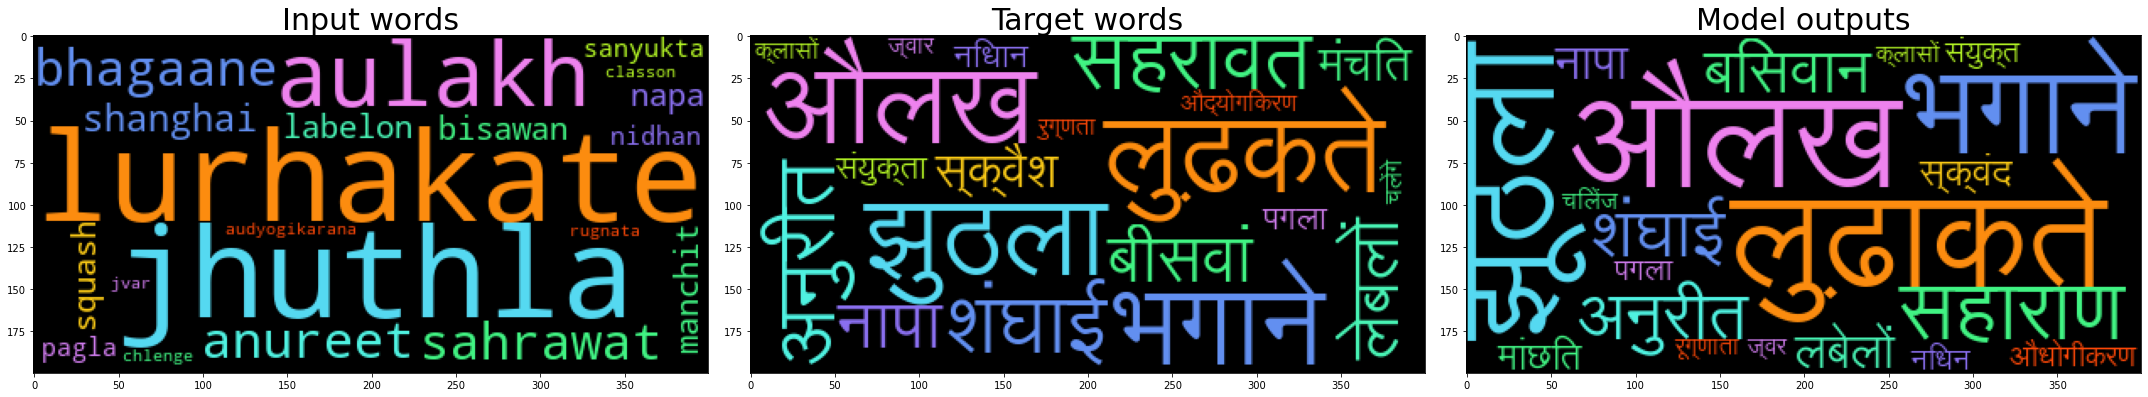

In [29]:
visualize_model_outputs(model, n=20)

In [30]:
def get_test_words(n):
    test_df = pd.read_csv(get_data_files("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['parwa', 'shawn', 'nauu', 'scandinavia', 'gaye']


In [31]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

Original Word: parwa
Transliterated Word: पर्व
Connectivity Visualization for प :


Connectivity Visualization for र :


Connectivity Visualization for ् :


Connectivity Visualization for व :


Original Word: shawn
Transliterated Word: शवन
Connectivity Visualization for श :


Connectivity Visualization for व :


Connectivity Visualization for न :


Original Word: nauu
Transliterated Word: नौ
Connectivity Visualization for न :


Connectivity Visualization for ौ :


Original Word: scandinavia
Transliterated Word: स्केंग्राइना
Connectivity Visualization for स :


Connectivity Visualization for ् :


Connectivity Visualization for क :


Connectivity Visualization for े :


Connectivity Visualization for ं :


Connectivity Visualization for ग :


Connectivity Visualization for ् :


Connectivity Visualization for र :


Connectivity Visualization for ा :


Connectivity Visualization for इ :


Connectivity Visualization for न :


Connectivity Visualization for ा :


Original Word: gaye
Transliterated Word: गाये
Connectivity Visualization for ग :


Connectivity Visualization for ा :


Connectivity Visualization for य :


Connectivity Visualization for े :


In [32]:
randomly_evaluate(model, n=5)

Randomly evaluating the model on 5 words

Input word: jasmeet
Actual translation: जसमीत
Model translation: जसमीत

Input word: mohim
Actual translation: मोहिम
Model translation: मोहिम

Input word: vidhansabhaein
Actual translation: विधानसभाएं
Model translation: विधानसभाएं

Input word: awaru
Actual translation: अवरु
Model translation: अवरू

Input word: latkate
Actual translation: लटकाते
Model translation: लटकते



In [33]:
def train_with_wandb(language, test_beam_search=False):

    config_defaults = {"layer_type": "lstm",
                       "embedding_dim": 64,
                       "dropout": 0.2, 
                       "units": 128,
                       "enc_dec_layers": 1,
                       "attention": False,
                       "beam_width": 0,
                       "teacher_forcing_ratio": 0
                       }

    wandb.init(config=config_defaults, project="cs6910-assignment3", resume=True)
    # Below is an example of a custom run name for sweep 4
    # This line was different for all sweeps
    #wandb.run.name = f"beam_width_{wandb.config.beam_width}"

    ## 1. SELECT LANGUAGE ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    ## 2. DATA PREPROCESSING ##
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embedding_dim=wandb.config.embedding_dim,
                         encoder_layers=wandb.config.enc_dec_layers,
                         decoder_layers=wandb.config.enc_dec_layers,
                         layer_type=wandb.config.layer_type,
                         units=wandb.config.units,
                         dropout=wandb.config.dropout,
                         attention=wandb.config.attention)
    
    ## 4. COMPILING THE MODEL 
    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())
    
    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=30, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)

In [34]:
sweep_config = {
  "name": "Sweep 1- Assignment3",
  "method": "grid",
  "parameters": {
        "layer_type": {
           "values": ["rnn", "gru", "lstm"]
        },
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [64, 128, 256]
        }
    }
}

In [35]:
sweep_id = wandb.sweep(sweep_config, project="cs6910-assignment3")

Create sweep with ID: b0671hc7
Sweep URL: https://wandb.ai/anuj-sougat/cs6910-assignment3/sweeps/b0671hc7


In [36]:
wandb.agent(sweep_id, function=lambda: train_with_wandb("hi"))

wandb: Agent Starting Run: y76rg6wl with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9908
Batch 100 Loss 1.3001
Batch 200 Loss 1.1618
Batch 300 Loss 1.2100

Validating ...

Train Loss: 1.3242 Train Accuracy: 61.9828 Validation Loss: 1.6258 Validation Accuracy: 51.7617

Time taken for the epoch 25.1813
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0911
Batch 100 Loss 1.1057
Batch 200 Loss 1.1660
Batch 300 Loss 1.1304

Validating ...

Train Loss: 1.1160 Train Accuracy: 68.8473 Validation Loss: 1.7186 Validation Accuracy: 49.0637

Time taken for the epoch 8.3840
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0841
Batch 100 Loss 1.0776
Batch 200 Loss 1.0779
Batch 300 Loss 1.0975

Validating ...

Train Loss: 1.0787 Train Accuracy: 69.5528 Validation Loss: 

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▅▁██▇▅▃▂▆▁▄▆▆▅▇▆▃▅▆▇▄▄▂▆▃▅▄▂▄▃
val loss,▁▂▁▂▃▅▆▇▅█▇▆▆▇▆▆▇▇▆▇▇██▆█▇▇█▇█
epoch,30
train acc,79.42382
train loss,0.66266
training time,8.25892
val acc,50.43159


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cak5jvp3 with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.0115
Batch 100 Loss 1.1201
Batch 200 Loss 1.0821
Batch 300 Loss 1.0826

Validating ...

Train Loss: 1.1942 Train Accuracy: 64.5833 Validation Loss: 1.6159 Validation Accuracy: 54.7600

Time taken for the epoch 30.6565
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0509
Batch 100 Loss 1.0284
Batch 200 Loss 0.9928
Batch 300 Loss 1.0317

Validating ...

Train Loss: 1.0129 Train Accuracy: 71.0921 Validation Loss: 1.8612 Validation Accuracy: 51.2493

Time taken for the epoch 12.9393
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9943
Batch 100 Loss 0.9267
Batch 200 Loss 0.9702
Batch 300 Loss 0.9112

Validating ...

Train Loss: 0.9461 Train Accuracy: 73.1101 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
train loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▆▄▃▇█▃▄▄▅▂▅▄▅▁▆▂▂▅▄▁▄▃▃▆▃▃▄▃▃▃
val loss,▁▃▃▂▂▅▅▅▅▆▅▅▅▇▅▇▇▆▆█▆▇▇▆▇▇▇█▇█
epoch,30
train acc,81.41282
train loss,0.59291
training time,12.97374
val acc,50.90192


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gk8u0c45 with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9981
Batch 100 Loss 1.2637
Batch 200 Loss 1.2921
Batch 300 Loss 1.2656

Validating ...

Train Loss: 1.3144 Train Accuracy: 64.2367 Validation Loss: 1.5868 Validation Accuracy: 57.2692

Time taken for the epoch 50.4531
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.2443
Batch 100 Loss 1.2677
Batch 200 Loss 1.2841
Batch 300 Loss 1.2543

Validating ...

Train Loss: 1.2783 Train Accuracy: 66.4601 Validation Loss: 1.5902 Validation Accuracy: 56.9415

Time taken for the epoch 33.7151
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.2664
Batch 100 Loss 1.2155
Batch 200 Loss 1.2344
Batch 300 Loss 1.2639

Validating ...

Train Loss: 1.2784 Train Accuracy: 66.2602 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁█▇██████████▇█████▇██▇█████▇█
train loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val acc,▆▃▄▃▃▁▆▆▅▅▄█▆▅▁▆▄▅▃▄▅▃▆▅█▆▇▅▂▄
val loss,▃▅▄▂▂▃▅▁▂▅█▂▁▂▄▁▂▅▄▃▄▇▇▃▇▅▃▄▄▄
epoch,30
train acc,66.40857
train loss,1.27581
training time,35.28771
val acc,57.04663


wandb: Agent Starting Run: urket3ku with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: gru
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9896
Batch 100 Loss 1.3394
Batch 200 Loss 1.1950
Batch 300 Loss 1.1133

Validating ...

Train Loss: 1.4480 Train Accuracy: 63.4741 Validation Loss: 1.6326 Validation Accuracy: 52.5312

Time taken for the epoch 49.1088
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1950
Batch 100 Loss 1.1531
Batch 200 Loss 1.1101
Batch 300 Loss 1.1266

Validating ...

Train Loss: 1.1287 Train Accuracy: 68.5414 Validation Loss: 1.5513 Validation Accuracy: 54.4771

Time taken for the epoch 16.2440
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.1063
Batch 100 Loss 1.1487
Batch 200 Loss 1.0973
Batch 300 Loss 1.0735

Validating ...

Train Loss: 1.1068 Train Accuracy: 68.9833 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train loss,█▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▂▁▂▂▂▂▂▃▂▃▃▄▅▄▅▅▆▆▅▇▇▇▇▇█▇███
val loss,█▇█▇▇▇▇▇▆▆▆▅▅▄▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,30
train acc,80.92609
train loss,0.5759
training time,16.69041
val acc,70.72499


wandb: Agent Starting Run: xocs97wc with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: gru
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9927
Batch 100 Loss 1.3080
Batch 200 Loss 1.1993
Batch 300 Loss 1.1432

Validating ...

Train Loss: 1.3659 Train Accuracy: 62.9883 Validation Loss: 1.5607 Validation Accuracy: 54.3340

Time taken for the epoch 71.2493
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1628
Batch 100 Loss 1.1532
Batch 200 Loss 1.0941
Batch 300 Loss 1.1269

Validating ...

Train Loss: 1.1209 Train Accuracy: 68.5416 Validation Loss: 1.5892 Validation Accuracy: 53.2387

Time taken for the epoch 39.4498
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0764
Batch 100 Loss 1.1397
Batch 200 Loss 1.0963
Batch 300 Loss 1.1120

Validating ...

Train Loss: 1.1067 Train Accuracy: 68.8782 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train loss,█▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val acc,▁▁▁▁▂▃▃▃▂▄▃▅▄▅▄▆▆▆▆▇▇▇▇▇██████
val loss,████▇▆▇▆▆▅▅▄▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,30
train acc,86.07337
train loss,0.40339
training time,38.71064
val acc,75.40625


wandb: Agent Starting Run: 9qjz70ag with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: gru
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9870
Batch 100 Loss 1.3131
Batch 200 Loss 1.1063
Batch 300 Loss 1.1375

Validating ...

Train Loss: 1.3104 Train Accuracy: 63.9435 Validation Loss: 1.5722 Validation Accuracy: 53.7104

Time taken for the epoch 116.9146
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1515
Batch 100 Loss 1.1269
Batch 200 Loss 1.0846
Batch 300 Loss 1.0709

Validating ...

Train Loss: 1.1122 Train Accuracy: 68.6961 Validation Loss: 1.4536 Validation Accuracy: 57.9159

Time taken for the epoch 84.4730
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.1232
Batch 100 Loss 1.1279
Batch 200 Loss 1.0332
Batch 300 Loss 1.0968

Validating ...

Train Loss: 1.0794 Train Accuracy: 69.2982 Validation Loss

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████
train loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇▇█▇▇█▇████████
val loss,█▇▇▇▆▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train acc,93.71888
train loss,0.19587
training time,85.3582
val acc,81.20466


wandb: Agent Starting Run: 5jsd3htg with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: lstm
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9860
Batch 100 Loss 1.3443
Batch 200 Loss 1.3332
Batch 300 Loss 1.1489

Validating ...

Train Loss: 1.4286 Train Accuracy: 61.9751 Validation Loss: 1.4472 Validation Accuracy: 59.6303

Time taken for the epoch 55.0980
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1128
Batch 100 Loss 1.1341
Batch 200 Loss 1.1086
Batch 300 Loss 1.1563

Validating ...

Train Loss: 1.1236 Train Accuracy: 68.6521 Validation Loss: 1.4028 Validation Accuracy: 59.9276

Time taken for the epoch 20.0922
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0901
Batch 100 Loss 1.1244
Batch 200 Loss 1.0977
Batch 300 Loss 1.1034

Validating ...

Train Loss: 1.1014 Train Accuracy: 68.8327 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇████████
train loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▁▁▂▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████
val loss,██▇▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train acc,84.70413
train loss,0.43632
training time,19.75913
val acc,78.5737


wandb: Agent Starting Run: w4q1ljtj with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: lstm
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9891
Batch 100 Loss 1.3081
Batch 200 Loss 1.3271
Batch 300 Loss 1.2162

Validating ...

Train Loss: 1.3651 Train Accuracy: 63.2926 Validation Loss: 1.4375 Validation Accuracy: 59.5694

Time taken for the epoch 84.3053
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0605
Batch 100 Loss 1.1215
Batch 200 Loss 1.0813
Batch 300 Loss 1.0883

Validating ...

Train Loss: 1.1169 Train Accuracy: 68.6500 Validation Loss: 1.3896 Validation Accuracy: 60.2235

Time taken for the epoch 48.1550
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.1156
Batch 100 Loss 1.1141
Batch 200 Loss 1.0922
Batch 300 Loss 1.0103

Validating ...

Train Loss: 1.0812 Train Accuracy: 69.1120 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train loss,█▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
val acc,▁▁▁▂▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇███████████
val loss,██▇▆▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train acc,89.73849
train loss,0.29599
training time,48.05307
val acc,81.55045


wandb: Agent Starting Run: beahfcet with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: lstm
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.0007
Batch 100 Loss 1.2159
Batch 200 Loss 1.1592
Batch 300 Loss 1.2155

Validating ...

Train Loss: 1.2491 Train Accuracy: 64.9153 Validation Loss: 1.6896 Validation Accuracy: 50.0598

Time taken for the epoch 146.8580
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0862
Batch 100 Loss 1.0192
Batch 200 Loss 1.0719
Batch 300 Loss 1.0745

Validating ...

Train Loss: 1.0881 Train Accuracy: 69.1502 Validation Loss: 1.5191 Validation Accuracy: 55.7390

Time taken for the epoch 107.4193
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0807
Batch 100 Loss 1.0965
Batch 200 Loss 1.0357
Batch 300 Loss 1.0468

Validating ...

Train Loss: 1.0525 Train Accuracy: 69.7838 Validation Los

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


Batch 200 Loss 0.2673
Batch 300 Loss 0.3051

Validating ...

Train Loss: 0.2894 Train Accuracy: 90.1557 Validation Loss: 0.5886 Validation Accuracy: 80.0820

Time taken for the epoch 110.4010
----------------------------------------------------------------------------------------------------
EPOCH 22

Training ...

Batch 1 Loss 0.2695
Batch 100 Loss 0.2763
Batch 200 Loss 0.2659
Batch 300 Loss 0.2836

Validating ...

Train Loss: 0.2716 Train Accuracy: 90.9853 Validation Loss: 0.6163 Validation Accuracy: 79.2575

Time taken for the epoch 108.6825
----------------------------------------------------------------------------------------------------
EPOCH 23

Training ...

Batch 1 Loss 0.2399
Batch 100 Loss 0.2898
Batch 200 Loss 0.2295
Batch 300 Loss 0.2363

Validating ...

Train Loss: 0.2554 Train Accuracy: 91.4388 Validation Loss: 0.6354 Validation Accuracy: 79.4958

Time taken for the epoch 108.9037
------------------------------------------------------------------------------------------

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
train loss,█▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁
val acc,▁▂▃▄▄▄▄▅▅▆▆▆▇▇▇▇▇█████████████
val loss,█▇▆▆▅▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch,30
train acc,94.52436
train loss,0.17097
training time,108.43168
val acc,80.06203


wandb: Agent Starting Run: kbex73e0 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.1149
Batch 100 Loss 1.4050
Batch 200 Loss 1.1821
Batch 300 Loss 1.1555

Validating ...

Train Loss: 1.3703 Train Accuracy: 61.0744 Validation Loss: 1.5184 Validation Accuracy: 56.3969

Time taken for the epoch 45.1668
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1953
Batch 100 Loss 1.1227
Batch 200 Loss 1.0300
Batch 300 Loss 1.1377

Validating ...

Train Loss: 1.1170 Train Accuracy: 68.8531 Validation Loss: 1.5147 Validation Accuracy: 55.8002

Time taken for the epoch 14.5060
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0968
Batch 100 Loss 1.0573
Batch 200 Loss 1.1009
Batch 300 Loss 1.1031

Validating ...

Train Loss: 1.0625 Train Accuracy: 70.2060 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
train loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,█▇▅█▆▇▄▅▇▄▃▄▃▄▄▂▄▄▃▂▃▃▄▅▄▃▁▃▄▃
val loss,▁▁▂▂▃▄▅▅▄▅▆▆▆▆▆▇▆▆▆▇▆▇▆▆▆▇█▇▇▇
epoch,30
train acc,80.59069
train loss,0.61435
training time,14.89471
val acc,50.45986


wandb: Agent Starting Run: q3vdoiu0 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.0557
Batch 100 Loss 1.2120
Batch 200 Loss 1.1220
Batch 300 Loss 1.1617

Validating ...

Train Loss: 1.2468 Train Accuracy: 64.9105 Validation Loss: 1.4712 Validation Accuracy: 58.7652

Time taken for the epoch 60.1747
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0822
Batch 100 Loss 1.1347
Batch 200 Loss 1.1198
Batch 300 Loss 1.0456

Validating ...

Train Loss: 1.0916 Train Accuracy: 69.3155 Validation Loss: 1.8885 Validation Accuracy: 49.0503

Time taken for the epoch 27.2465
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9570
Batch 100 Loss 0.9174
Batch 200 Loss 0.9643
Batch 300 Loss 0.9260

Validating ...

Train Loss: 0.9668 Train Accuracy: 72.5191 Validation Loss:

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
train loss,█▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁
val acc,█▃▅▅▅▄▄▅▃▅▃▃▄▃▃▂▅▄▃▄▃▃▂▂▃▄▃▁▂▄
val loss,▁▄▄▄▅▆▆▅▆▅▆▆▅▆▆▇▅▆▇▅▆▆▇▇▆▆▇██▆
epoch,30
train acc,83.38097
train loss,0.51418
training time,28.09038
val acc,49.82072


wandb: Agent Starting Run: x8b01mk7 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.1685
Batch 100 Loss 1.2376
Batch 200 Loss 1.3621
Batch 300 Loss 1.3602

Validating ...

Train Loss: 1.3222 Train Accuracy: 63.3870 Validation Loss: 1.5838 Validation Accuracy: 57.1656

Time taken for the epoch 112.5788
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.3294
Batch 100 Loss 1.3155


wandb: Ctrl + C detected. Stopping sweep.


In [37]:
# dropout Sweep
sweep_config2 = {
  "name": "Sweep 2- Assignment3",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [2, 3]
        },
        "dropout": {
            "values": [0.2, 0.3]
        },
        "embedding_dim": {
            "values": [64, 128, 256]
        }
    }
}

In [38]:
sweep_id2 = wandb.sweep(sweep_config2, project="cs6910-assignment3")

epoch,▁
train acc,▁
train loss,▁
training time,▁
val acc,▁
val loss,▁
epoch,1
train acc,63.387
train loss,1.32217
training time,112.57881
val acc,57.16558


Create sweep with ID: qyrpxbgx
Sweep URL: https://wandb.ai/anuj-sougat/cs6910-assignment3/sweeps/qyrpxbgx


In [39]:
wandb.agent(sweep_id2, function=lambda: train_with_wandb("hi"))

wandb: Agent Starting Run: j5lqqekx with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 64
wandb: 	enc_dec_layers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Tried to auto resume run with id x8b01mk7 but id j5lqqekx is set.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9930
Batch 100 Loss 1.2998
Batch 200 Loss 1.2984
Batch 300 Loss 1.1725

Validating ...

Train Loss: 1.3454 Train Accuracy: 64.1082 Validation Loss: 1.4195 Validation Accuracy: 59.4917

Time taken for the epoch 171.4967
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1188
Batch 100 Loss 1.1206
Batch 200 Loss 1.1795
Batch 300 Loss 1.1510

Validating ...

Train Loss: 1.1159 Train Accuracy: 68.6299 Validation Loss: 1.4212 Validation Accuracy: 59.7185

Time taken for the epoch 103.9153
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0927
Batch 100 Loss 1.0244
Batch 200 Loss 1.0826
Batch 300 Loss 1.0619

Validating ...

Train Loss: 1.0716 Train Accuracy: 69.1776 Validation Los

wandb: Ctrl + C detected. Stopping sweep.


In [40]:
# teacher_forcing sweep
sweep_config3 = {
  "name": "Sweep 3- Assignment3",
  "method": "grid",
  "parameters": {
        "teacher_forcing_ratio": {
            "values": [0.3, 0.5, 0.7, 0.9]
        },
        "enc_dec_layers": {
            "values": [2]
        },
        "dropout": {
            "values": [0.2]
        },
        "embedding_dim": {
            "values": [128]
        }
    }
}

In [41]:
sweep_id3 = wandb.sweep(sweep_config3, project="cs6910-assignment3")

Create sweep with ID: 7ldpik68
Sweep URL: https://wandb.ai/anuj-sougat/cs6910-assignment3/sweeps/7ldpik68


In [42]:
wandb.agent(sweep_id3, function=lambda: train_with_wandb("hi"))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: Agent Starting Run: 4oqp9vy1 with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.3


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train acc,▁▂▃▃▄▄▅▅▆▆▇▇▇███
train loss,█▆▆▆▅▄▄▃▃▂▂▂▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁▁▁▆▅▆▁
val acc,▁▁▂▂▄▄▅▅▆▇▇▇████
val loss,██▇▆▅▄▄▃▂▂▂▁▁▁▁▁
epoch,16
train acc,87.31126
train loss,0.36673
training time,105.73839
val acc,81.16332


Exception in thread Thread-152:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/agents/pyagent.py", line 300, in _run_job
    self._function()
  File "<ipython-input-39-f147c8d3131b>", line 1, in <lambda>
    wandb.agent(sweep_id2, function=lambda: train_with_wandb("hi"))
  File "<ipython-input-33-b7ef013f8d0c>", line 41, in train_with_wandb
    model.fit(dataset, val_dataset, epochs=30, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)
  File "<ipython-input-25-287b6dd9bb14>", line 389, in fit
    batch_loss, acc = self.train_step(input, target, enc_state)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/execute.py", line 55, in quick_execute
    inputs, attrs, num_outputs)
Exception

During handling of the above exception, another exc

----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9950
Batch 100 Loss 1.1196
Batch 200 Loss 1.1222
Batch 300 Loss 0.9561

Validating ...

Train Loss: 1.1889 Train Accuracy: 66.4678 Validation Loss: 1.7574 Validation Accuracy: 56.7544

Time taken for the epoch 179.5530
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9443
Batch 100 Loss 0.8984
Batch 200 Loss 0.8910
Batch 300 Loss 0.8633

Validating ...

Train Loss: 0.8923 Train Accuracy: 73.9009 Validation Loss: 2.3114 Validation Accuracy: 51.3166

Time taken for the epoch 111.5255
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8777
Batch 100 Loss 0.8056
Batch 200 Loss 0.8085
Batch 300 Loss 0.7511

Validating ...

Train Loss: 0.7966 Train Accuracy: 75.6950 Validation Los

wandb: Ctrl + C detected. Stopping sweep.


In [43]:
# Attention Sweep
sweep_config4 = {
  "name": "Attention Sweep - Assignment3",
  "description": "Hyperparameter sweep for Seq2Seq Model with Attention",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [128, 256]
        },
        "dropout": {
            "values": [0, 0.2]
        },
        "attention": {
            "values": [True]
        }
    }
}

In [44]:
sweep_id4 = wandb.sweep(sweep_config4, project="cs6910-assignment3")

Create sweep with ID: fddm5oci
Sweep URL: https://wandb.ai/anuj-sougat/cs6910-assignment3/sweeps/fddm5oci


In [ ]:
wandb.agent(sweep_id4, function=lambda: train_with_wandb("hi"), project="cs6910-assignment3")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: vhjp12z3 with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 128


epoch,▁▅█
train acc,▁▇█
train loss,█▃▁
training time,█▁▁
val acc,█▃▁
val loss,▁▆█
epoch,3
train acc,75.69502
train loss,0.79657
training time,111.11763
val acc,48.81046


Exception in thread Thread-162:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/agents/pyagent.py", line 300, in _run_job
    self._function()
  File "<ipython-input-42-9be58fd47ea6>", line 1, in <lambda>
    wandb.agent(sweep_id3, function=lambda: train_with_wandb("hi"))
  File "<ipython-input-33-b7ef013f8d0c>", line 41, in train_with_wandb
    model.fit(dataset, val_dataset, epochs=30, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)
  File "<ipython-input-25-287b6dd9bb14>", line 389, in fit
    batch_loss, acc = self.train_step(input, target, enc_state)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/execute.py", line 55, in quick_execute
    inputs, attrs, num_outputs)
Exception

During handling of the above exception, another exc

----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9847
Batch 100 Loss 1.2324
Batch 200 Loss 1.1756
Batch 300 Loss 1.1186

Validating ...

Train Loss: 1.2786 Train Accuracy: 64.8262 Validation Loss: 1.5262 Validation Accuracy: 56.1040

Time taken for the epoch 272.3178
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1660
Batch 100 Loss 1.0757
Batch 200 Loss 1.1270
Batch 300 Loss 1.1190

Validating ...

Train Loss: 1.0977 Train Accuracy: 68.9029 Validation Loss: 1.5017 Validation Accuracy: 55.9019

Time taken for the epoch 130.1642
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0472
Batch 100 Loss 1.0585
Batch 200 Loss 1.0644
Batch 300 Loss 1.0632

Validating ...

Train Loss: 1.0699 Train Accuracy: 69.5531 Validation Los

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train acc,▁▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
train loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
training time,█▂▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▁▁▂▃▄▄▅▄▅▆▅▅▆▆▇▇▇▇▇▇▇▇█▇██▇██
val loss,███▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▁
epoch,30
train acc,90.3764
train loss,0.2849
training time,116.1467
val acc,79.98083


wandb: Agent Starting Run: whdqbmyr with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9873
Batch 100 Loss 1.2052
Batch 200 Loss 1.1233
Batch 300 Loss 1.1063

Validating ...

Train Loss: 1.2371 Train Accuracy: 65.0862 Validation Loss: 1.5438 Validation Accuracy: 55.0236

Time taken for the epoch 353.3843
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1193
Batch 100 Loss 1.1139
Batch 200 Loss 1.0310
Batch 300 Loss 1.0785

Validating ...

Train Loss: 1.0867 Train Accuracy: 69.0861 Validation Loss: 1.4679 Validation Accuracy: 57.2460

Time taken for the epoch 307.5913
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0774
Batch 100 Loss 1.0999
Batch 200 Loss 1.0119
Batch 300 Loss 0.9951

Validating ...

Train Loss: 1.0386 Train Accuracy: 70.0513 Validation Los